In [1]:
import numpy as np
import pandas as pd
import gc
from multiprocessing import Pool
import cmasher as cmr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=Warning) 
import matplotlib.colors as colors


from os import path

import yt
from yt import YTArray

import numpy as np
from yt.units import G
import array
import pandas as pd


In [2]:
path_csv = "/media/temp/bego/snapshots_resim/"
path_datos = "/home/bego/GARROTXA_copia/datos_GARROTXA_resim/"
path_results = "/home/bego/GARROTXA/GalaDyn/results/"
path_crossmatch = "/home/bego/GARROTXA/satelites_crossmatch/"
path_figures_acceleration = "/home/bego/GARROTXA/acceleration_figures/"
path_figures = "/home/bego/GARROTXA/acceleration_figures/"
path_acceleration = "/home/bego/GARROTXA/acceleration/"
path_disk = "/home/bego/GARROTXA/disco/"

In [3]:
datos_edades = pd.read_csv(path_datos + "edades.csv", sep = ",",index_col = 0)
class Snapshot:
    def __init__(self, name):
        self.name = name
        self.path_snapshot = None
        self.lb = None
        self.center = None
        self.Rvir = None
        self.ds = None 
        self.dm = None
        self.gas = None
        self.stars = None
        self.disk = None


        def read_lb():
            self.lb = datos_edades.loc[datos_edades['Snapshot'] == self.name, 'Lookback'].iloc[0]

        def read_center_Rvir ():
            centro = np.loadtxt(path_datos +f'center_{self.name}.txt')
            center = YTArray([centro[0], centro[1], centro[2]], "cm")
        #   cx,cy,cz = center[0].in_units("cm"), center[1].in_units("cm"),  center[2].in_units("cm")
            Rvir = YTArray(centro[3], "kpc")
            self.center = center
            self.Rvir = Rvir

        def find_path_for_yt():
            # name = snapshots_analysis[i]
            if self.name < 425:
                path_snapshot = "/media/temp1/bego/GARROTXA_ART/"
            elif (self.name >= 425)&(name < 600):
                path_snapshot = "/srv/cab1/garrotxa/GARROTXA_ART/MW_003/RUN2.2/"
            elif (self.name >=600 )&(name < 800):
                path_snapshot = "/home/Garrotxa_ART/New_Run/"
            elif (self.name >= 800) & (name < 900) :
                path_snapshot = "/media/temp/bego/New_Resim/"
            elif self.name >= 900 :
                path_snapshot = "/media/temp1/GARROTXA_ART/MW_003/RUN2.2/"
            self.path_snapshot = path_snapshot
        
        print(f"Initializing snapshot {name}")
        find_path_for_yt()
        read_lb()
        print(f"Lookback time: {self.lb} Gyr")
        read_center_Rvir()
        
    def load_stars (self):
        self.stars = pd.read_csv(path_csv + f"{self.name}_stars_Rvir.csv",sep = ",")
        self.stars = cartesian_to_cylindrical(self.stars)

    def load_dm (self):
        self.dm = pd.read_csv(path_csv + f"{self.name}_dm_Rvir.csv",sep = ",")
        self.dm = cartesian_to_cylindrical(self.dm)

    def load_gas (self):
        self.gas = pd.read_csv(path_csv + f"Gas_{self.name}.csv",sep = ",")
        self.gas = cartesian_to_cylindrical(self.gas)

    def load_disk(self):
        self.disk = pd.read_csv(path_disk + f"Stars_disco_{self.name}.csv")

    def filter_disk_particles(self):
        dfA = self.stars[self.stars['ID'].isin(self.disk["ID"])]
        df = dfA[(dfA['R']< 25)].copy()
        df["Phi"] = np.mod(np.arctan2(df["Y"], df["X"]), 2*np.pi)
        df["R"] = np.sqrt(df["X"]**2 + df["Y"]**2)
        return df




In [122]:

ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",")
ac_gas= pd.read_csv(path_acceleration +f"mesh_aceleracion_gas_{name}_ytRS_40.csv", sep = ",")
ac_disk= pd.read_csv(path_acceleration +f"mesh_aceleracion_stars_disk_{name}_ytRS.csv", sep = ",")
#ac_nodisk = 
plt.style.use('dark_background')

FileNotFoundError: [Errno 2] No such file or directory: '/home/bego/GARROTXA/acceleration/mesh_aceleracion_stars_disk_520_ytRS.csv'

In [126]:
#rangos = [5e-15, 1e-15, 9e-16, 8e-16]
def plot_acceleration_z(name):
    snapshot = Snapshot(name)
    ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",")
    ac_gas= pd.read_csv(path_acceleration +f"mesh_aceleracion_gas_{name}_ytRS_40.csv", sep = ",")
    ac_disk= pd.read_csv(path_acceleration +f"mesh_aceleracion_stars_disk_{name}_ytRS.csv", sep = ",")
    rango = 1e-14
    nn = 1.10
    ancho = 45
    #bounds = np.linspace(-rango, rango, num=10)
    #bounds = np.array([-rangos[0],-rangos[1],-rangos[2],-rangos[3],0,rangos[3],rangos[2],rangos[1],rangos[0]])
    x_bins = np.arange(-ancho,ancho,0.7)
    y_bins = np.arange(-ancho,ancho,0.7)

    x_bins_disk = np.arange(-20,20,0.7)
    y_bins_disk  = np.arange(-20,20,0.7)
    H_dm, xedges_dm, yedges_dm = np.histogram2d(ac_dm.X, ac_dm.Y,bins=[x_bins,y_bins],
                                                  weights = ac_dm.az.values)

    H_gas, xedges_gas, yedges_gas = np.histogram2d(ac_gas.X, ac_gas.Y,bins=[x_bins,y_bins],
                                                  weights = ac_gas.az.values)

    H_disk, xedges_disk, yedges_disk = np.histogram2d(ac_disk.X, ac_disk.Y,bins=[x_bins_disk,y_bins_disk],
                                                  weights = ac_disk.az.values)


    #norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
    #norm=matplotlib.colors.LogNorm()
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True,figsize = (14,4))
    fig.subplots_adjust(hspace=0.2, wspace=0.15)

    az = ax[0].scatter(ac_dm.X, ac_dm.Y, marker='s', c=ac_dm.az, 
                cmap= "seismic", s = 10, vmin =-rango, vmax = rango,norm=colors.PowerNorm(gamma = nn))

    ax[1].set_title (f"{snapshot.lb:0.2f} Gyr", fontsize = 14)
    ax[1].scatter(ac_gas.X, ac_gas.Y, marker='s', c=ac_gas.az, 
                cmap= "seismic", s = 10, vmin =-rango, vmax = rango,norm=colors.PowerNorm(gamma = nn))

    ax[2].scatter(ac_disk.X, ac_disk.Y, marker='s', c=ac_disk.az, 
                cmap= "seismic", s = 10, vmin =-rango, vmax = rango,norm=colors.PowerNorm(gamma = nn))

    ax[0].text(-42, 40, "Dark Matter", fontsize = 12, alpha = 0.9)
    ax[1].text(-42, 40, "Gas", fontsize = 12, alpha = 0.9)
    ax[2].text(-42, 40, "Disk", fontsize = 12, alpha = 0.9)

    for i in range(3):
        ax[i].set_xlabel("X [kpc]")
        ax[i].set_ylabel("Y [kpc]")
        ax[i].set_xlim(-ancho,ancho)
        ax[i].set_ylim(-ancho,ancho)

    cbar_ax_ar = fig.add_axes([0.66, 0.95, 0.235, 0.008])
    cbar_ar  = fig.colorbar(az, cax=cbar_ax_ar , orientation = "horizontal", label=  "[km/$s^2$]")          
    cbar_ar.ax.tick_params(labelsize= 10, top= True,bottom= False,
               labeltop=True,  labelbottom= False)

    plt.savefig(path_figures_acceleration + f"acceleration_z_{name}.png", format='png', dpi=150, bbox_inches='tight')

In [134]:
snapshots_analysis = [
#602,604, 608, 610, 612, 614, 616, 618, 620, 622, 624, 626, 
#629, 630, 632, 634, 636, 639, 640, 642, 644, 646, 648, 650, 652, 654, 656, 658, 660, 662, 
#664, 666, 668,670, 672, 674, 676, 679, 681, 682, 684, 687, 689,
#690, 692, 694, 698, 704, 706, 708,711, 712,714, 716, 718, 720, 
#722, 724, 726, 728, 731, 732, 734, 736, 739, 740, 742, 744, 746, 748, 751,752,
# 755, 756, 758, 761,763, 764, 766, 768, 770, 772, 774, 776, 778,780, 
#782, 784, 786, 788, 790, 792, 794, 797, 798, 802, 805, 806, 808, 810, 812, 814, 816,
# 818, 820, 822, 824, 826, 828, 
#830, 832, 834, 836, 839, 840, 842, 844, 846, 848, 850,
#853, 855, 856, 858, 860, 862, 864, 867, 870, 872, 875, 877, 879, 881, 883, 884,
    888,
890, 892, 894, 898, 900, 902, 904, 907, 908, 910, 912, 915, 
916, 918, 921, 922, 924, 927, 929, 
930, 932, 934, 937, 939, 941,942, 944, 946, 948, 950, 952, 954,956, 
958, 961, 963, 965, 966, 968, 970, 972, 974, 976, 979,
 980, 982, 984, 989, 990, 993, 994, 996, 999] 

888
Initializing snapshot 888
Lookback time: 1.6803821053718089 Gyr
890
Initializing snapshot 890
Lookback time: 1.6513349419549357 Gyr
892
Initializing snapshot 892
Lookback time: 1.6221933386695184 Gyr
894
Initializing snapshot 894
Lookback time: 1.5913968824946192 Gyr
898
Initializing snapshot 898
Lookback time: 1.526482000440085 Gyr
900
Initializing snapshot 900
Lookback time: 1.4921852356211271 Gyr
902
Initializing snapshot 902
Lookback time: 1.4740895780518706 Gyr
904
Initializing snapshot 904
Lookback time: 1.4378104691953375 Gyr
907
Initializing snapshot 907
Lookback time: 1.3995344473201283 Gyr
908
Initializing snapshot 908
Lookback time: 1.379394815045762 Gyr
910
Initializing snapshot 910
Lookback time: 1.3389136775111898 Gyr
912
Initializing snapshot 912
Lookback time: 1.3186343746780445 Gyr
915
Initializing snapshot 915
Lookback time: 1.2736795703077617 Gyr
916
Initializing snapshot 916
Lookback time: 1.2511075261369928 Gyr
918
Initializing snapshot 918
Lookback time: 1.228

FileNotFoundError: [Errno 2] No such file or directory: '/home/bego/GARROTXA/acceleration/mesh_aceleracion_dm_939_ytRS_40.csv'

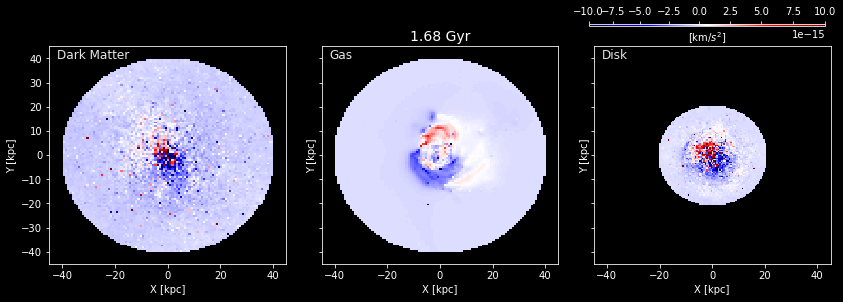

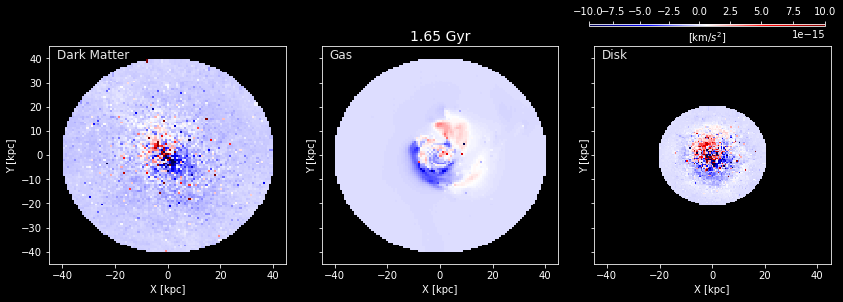

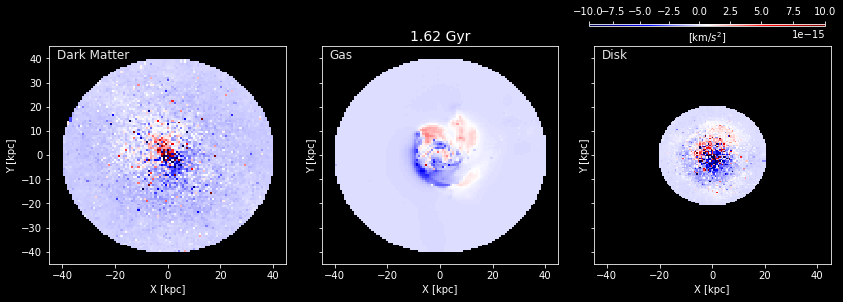

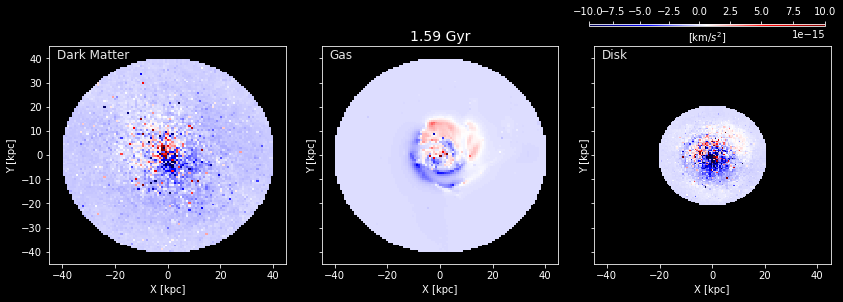

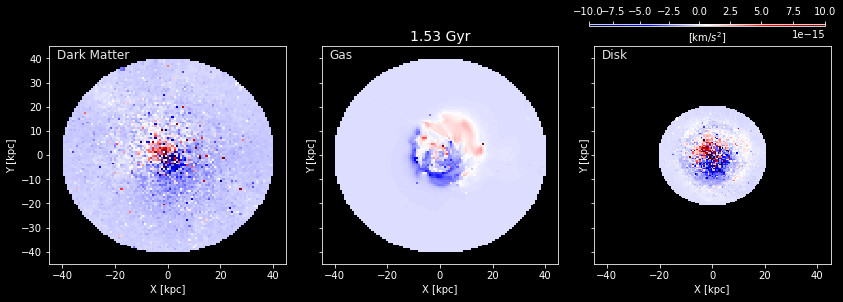

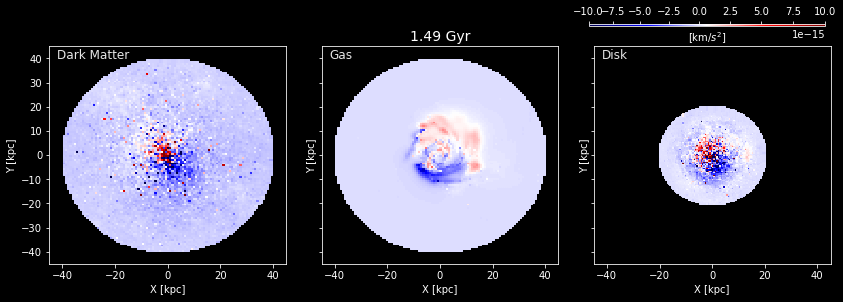

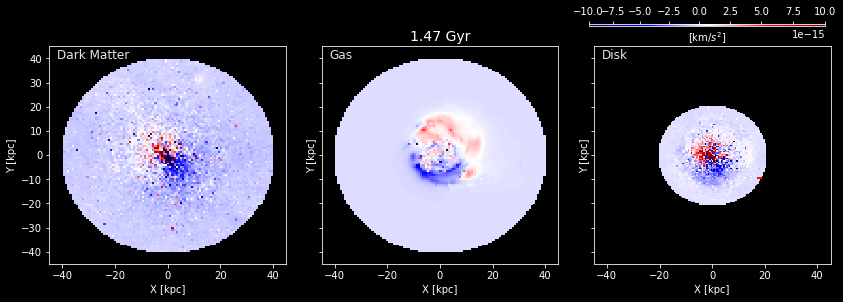

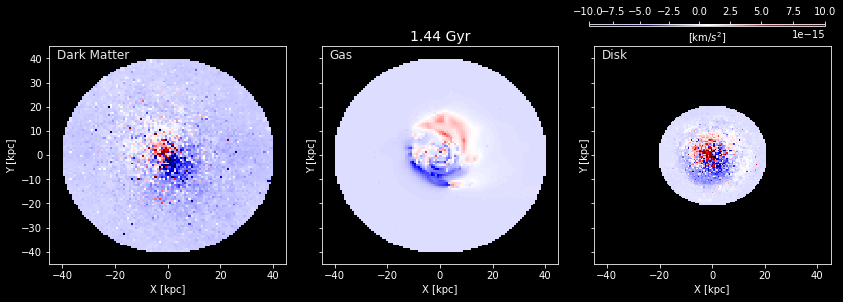

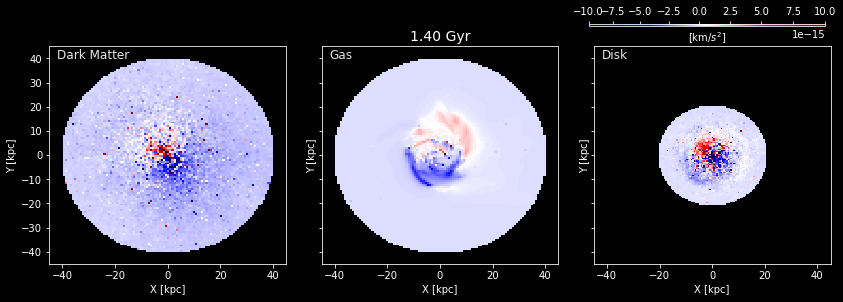

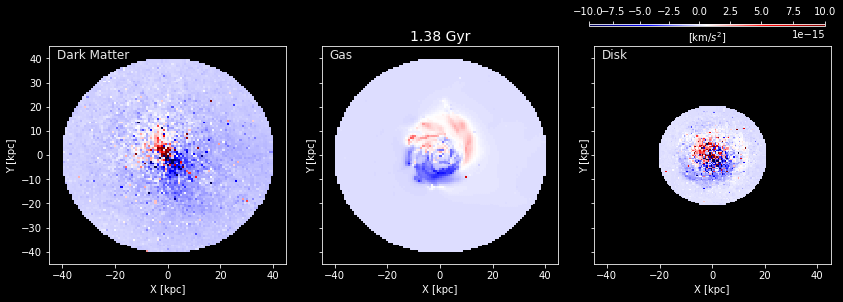

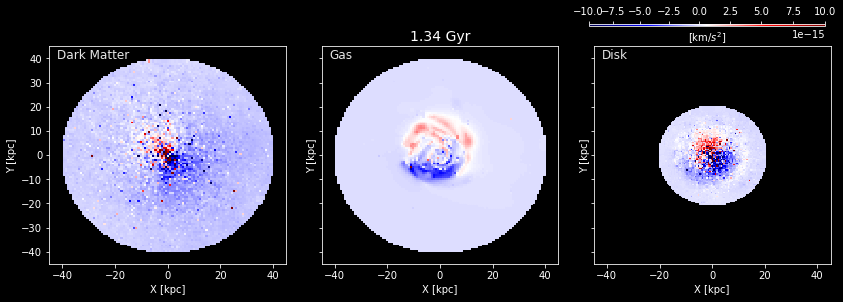

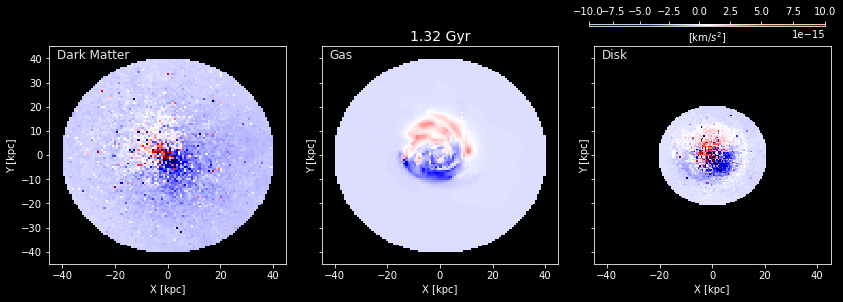

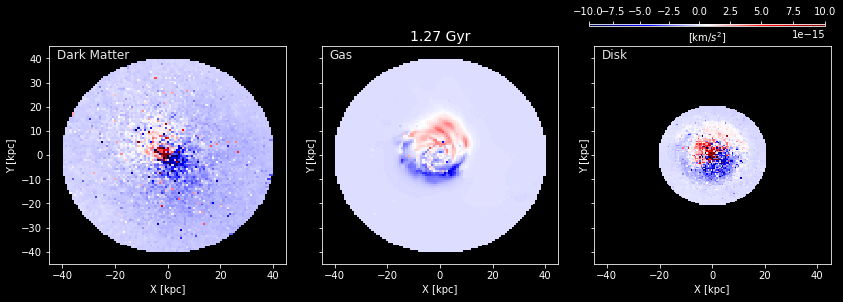

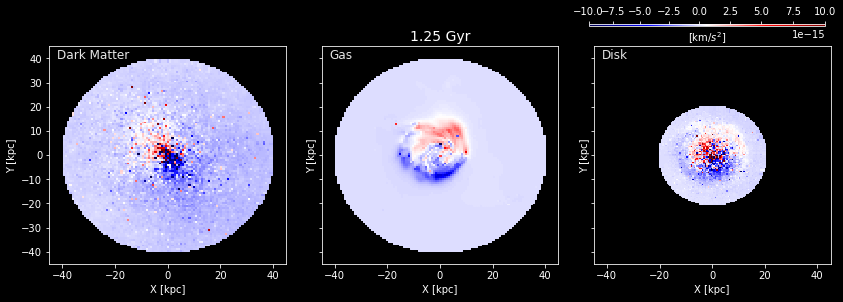

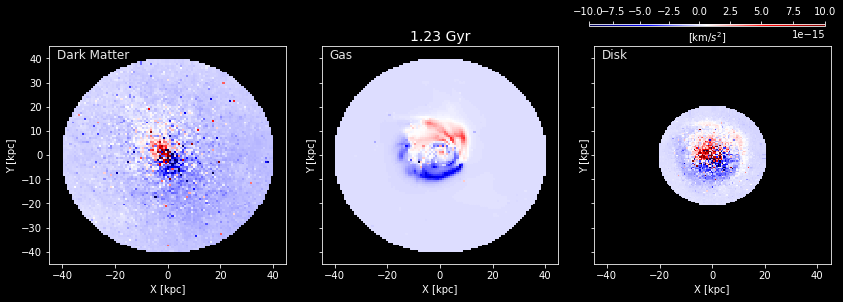

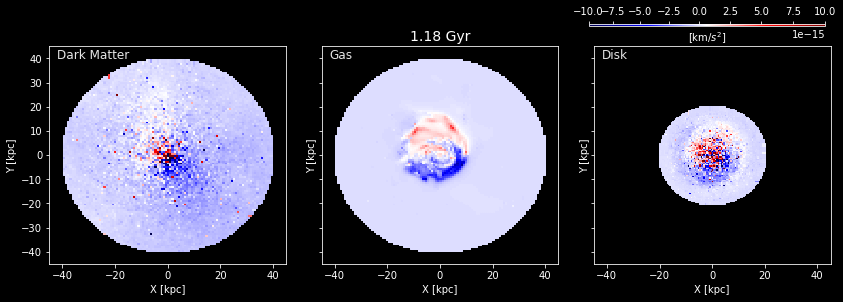

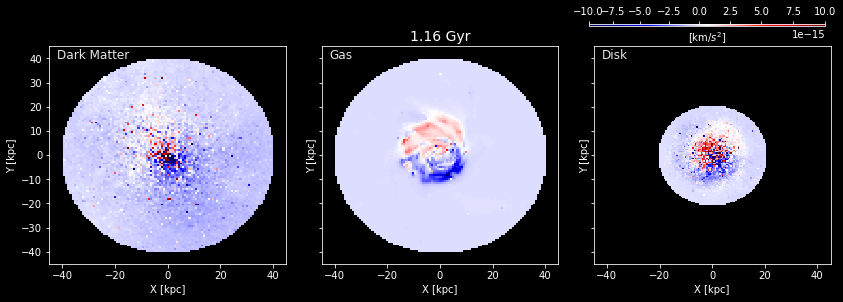

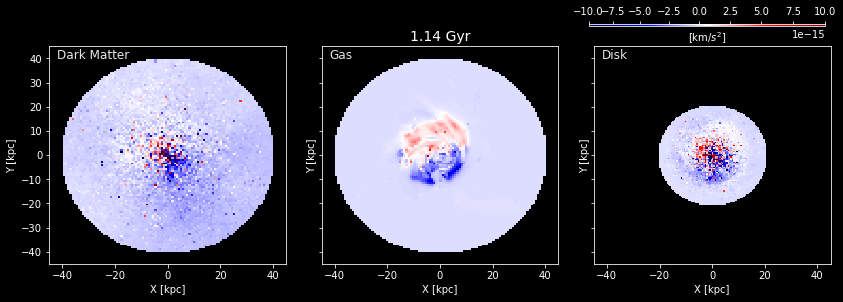

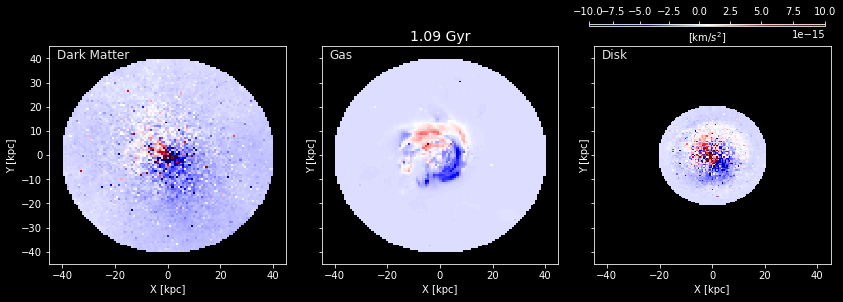

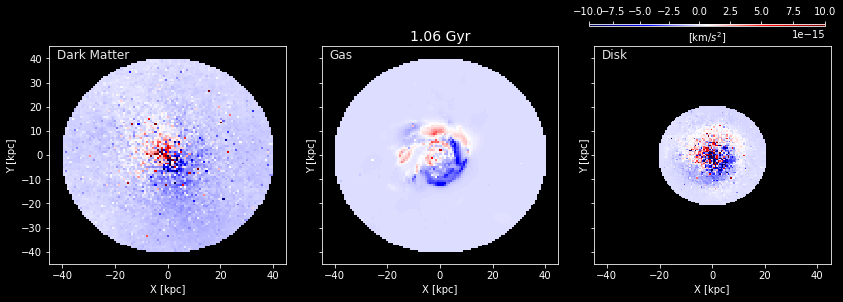

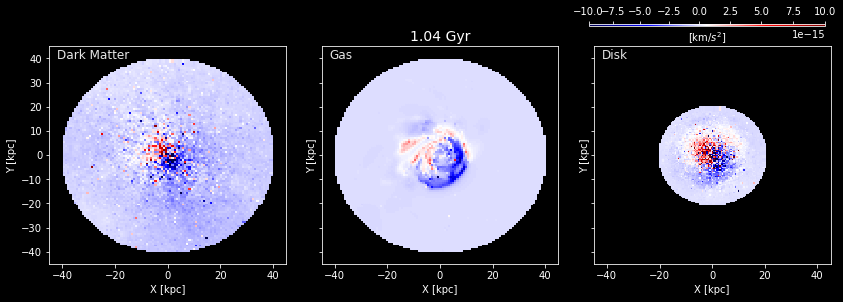

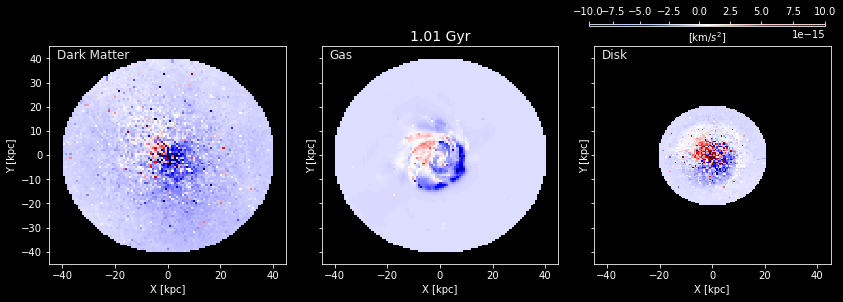

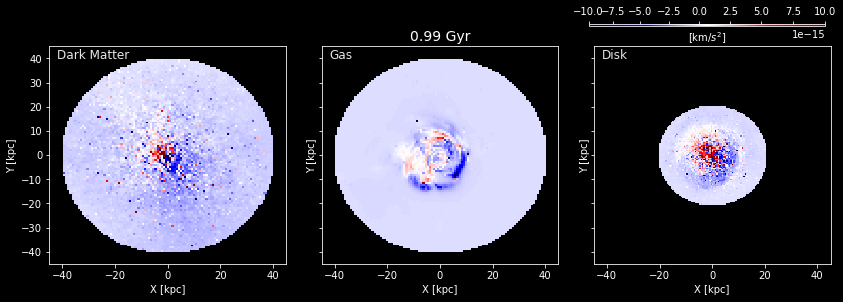

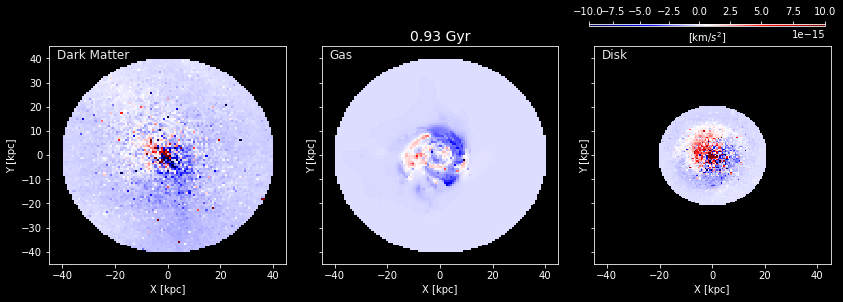

In [135]:
for name in snapshots_analysis:
    print(name)
    plot_acceleration_z(name)